In [2]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import matplotlib.pyplot as plt
import math

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py

def load_dataset(is_normalize=True):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader) # skip the first row
        temp_data = []
        temp_label = []
        
        for idx, row in enumerate(reader):            
            slice_row = row[1:45] + row[46:]
            temp_data.append(slice_row)
            temp_label.append(row[45])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))    
        
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            dataset = scaler.fit_transform(dataset)
           
            labels = np.array(labels).reshape(len(labels), 1)
            scaler = preprocessing.MinMaxScaler()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')
            
    return np.array(dataset), np.array(labels).reshape(len(labels), 1)

In [39]:
# Load dataset 
dataset = []
labels = []
# ori_dataset, ori_labels = load_dataset(is_normalize=False) 
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

Data is normalize
Dataset shape: (39644, 59), Labels: (39644, 1)
x_train: (31715, 59), y_train: (31715, 1)
x_test: (7929, 59), y_test: (7929, 1)


dataset (39644, 59)
labels (39644, 1)
Labels max value: 1.0
Labels min value: 0.0
Labels avg value: 0.45743886217973123


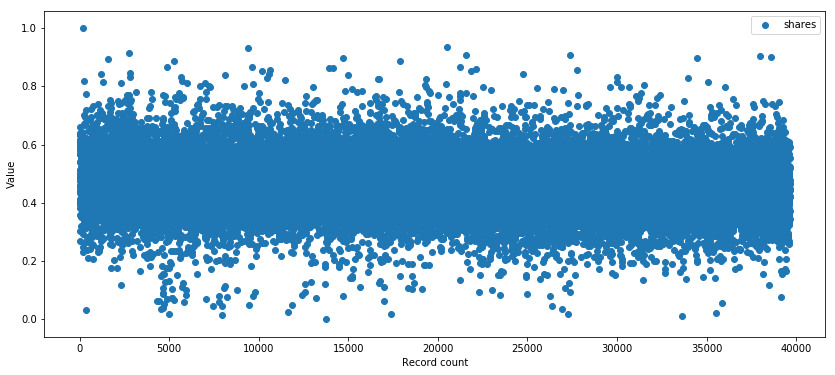

In [40]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

In [35]:
# build model
model = Sequential()
model.add(Dense(128, input_dim=59, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.0001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               7680      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total para

In [36]:
# training with callbacks
saved_weights_name = 'best_weights_mlp.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=6,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=0.000001,
                              verbose=1)
    
model.fit(x_train, y_train,
          epochs=10,
          validation_data=(x_test, y_test),
          callbacks=[early_stop, reduce_lr],
          verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/10
31715/31715 [==============================] - 2s 60us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2/10
31715/31715 [==============================] - 2s 51us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 3/10
31715/31715 [==============================] - 2s 51us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/10
31715/31715 [==============================] - 2s 51us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/10
31715/31715 [==============================] - 2s 52us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/10
31715/31715 [==============================] - 2s 55us/step - loss: 0.0036 - mean_squared_error: 0.0036 -

7929/7929 [==============================] - 0s 23us/step
loss: 0.001913
mean_squared_error: 0.001913
explained_variance_score: 0.420326
mean_absolute_error: 0.031317
mean_squared_log_error: 0.000872
median_absolute_error: 0.023199
r2_score: 0.418104


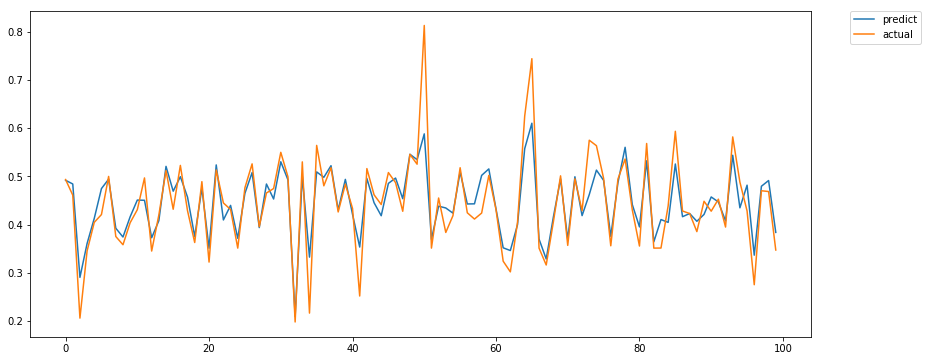

In [37]:
# showing results
scores = model.evaluate(x_test, y_test)
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

plt.figure(figsize=(14,6))
plt.plot(y_pred[:100], label="predict")
plt.plot(y_test[:100], label="actual")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()